In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from peewee import *
import datetime
from datetime import date, datetime, timedelta
import matplotlib.dates as mdates
import re
from dateutil.relativedelta import relativedelta 

In [5]:
db = MySQLDatabase('airfaresdwh', user='root', password='root', host='localhost', autocommit=True)

In [6]:
class DimFlight(Model):

    flightKey = CharField(max_length=255)
    flightID = AutoField(primary_key=True, index=True)
    flightNumber = CharField(max_length=50)
    departureDate = DateField()
    arrivalDate = DateField()
    departureTime = TimeField()
    arrivalTime = TimeField()
    journeyDuration = TimeField()
    totalNumberOfStops = IntegerField()
    startDate = DateField()
    endDate = DateField()

    class Meta:
        database = db

class DimAirline(Model):
    carrierID = AutoField(primary_key=True)
    carrierCode = CharField(max_length=10)
    carrierName = CharField(max_length=50)

    class Meta:
        database = db

class DimAirport(Model):
    airportID = AutoField(primary_key=True)
    airportCode = CharField(max_length=10)
    airportName = CharField(max_length=50)
    city = CharField(max_length=50)
    country = CharField(max_length=50)

    class Meta:
        database = db

class DimDate(Model):
    dateID = IntegerField(primary_key=True)
    fullDate = DateField()
    dayOfMonth = IntegerField()
    dayOfYear = IntegerField()
    dayOfWeek = IntegerField()
    dayName = CharField(max_length=10)
    monthNumber = IntegerField()
    monthName = CharField(max_length=10)
    year = IntegerField()
    isItWeekend = IntegerField()
    isItVacationDay = IntegerField()
    week_of_year = CharField(max_length=2)
    quarter = IntegerField()
    previous_day = DateField()
    next_day = DateField()

    class Meta:
        database = db

class FactFlights(Model):
    factID = AutoField()
    scrapeDateID = IntegerField()
    depAirportID = IntegerField()
    arrAirportID = IntegerField()
    flightID = IntegerField()
    carrierID = IntegerField()
    departureDateID = IntegerField()
    arrivalDateID = IntegerField()
    availableSeats = IntegerField()
    adultPrice = FloatField()

    class Meta:
        database = db

    def create_foreign_keys(self):
        self.flightID = ForeignKeyField(DimFlight, backref='fact_flights')
        self.carrierID = ForeignKeyField(DimAirline, backref='fact_flights')
        self.depAirportID = ForeignKeyField(DimAirport, backref='fact_flights_dep')
        self.arrAirportID = ForeignKeyField(DimAirport, backref='fact_flights_arr')
        self.departureDateID = ForeignKeyField(DimDate, backref='fact_flights_dep')
        self.arrivalDateID = ForeignKeyField(DimDate, backref='fact_flights_arr')
        self.scrapeDateID = ForeignKeyField(DimDate, backref='fact_flights_scrape')



In [7]:
db.connect()
query1 = DimFlight.select().dicts()
query2 = DimDate.select().dicts()
query3 = DimAirport.select().dicts()
query4 = DimAirline.select().dicts()
query5 = FactFlights.select().dicts()

flight_data = list(query1)
date_data = list(query2)
airport_data = list(query3)
airline_data = list(query4)
fact_flights_data = list(query5)

df_flight = pd.DataFrame(flight_data)
df_date = pd.DataFrame(date_data)
df_airport = pd.DataFrame(airport_data)
df_airline = pd.DataFrame(airline_data)
df_fact_flights = pd.DataFrame(fact_flights_data)
db.close()

True

### (1) Welke vliegtuigmaatschappij is gemiddeld de goedkoopste / de duurste?

##### Ryanair

In [5]:
ryanair_mean_price = df_fact_flights[df_fact_flights['carrierID'] == 3]['adultPrice'].mean()
ryanair_mean_price

115.7288261749494

##### Tui

In [6]:
tui_mean_price = df_fact_flights[df_fact_flights['carrierID'] == 2]['adultPrice'].mean()
tui_mean_price

200.67144448373406

##### Transavia

In [7]:
transavia_mean_price = df_fact_flights[df_fact_flights['carrierID'] == 1]['adultPrice'].mean()
transavia_mean_price

146.58736317831702

Text(0.5, 0, 'Gemiddlede prijs')

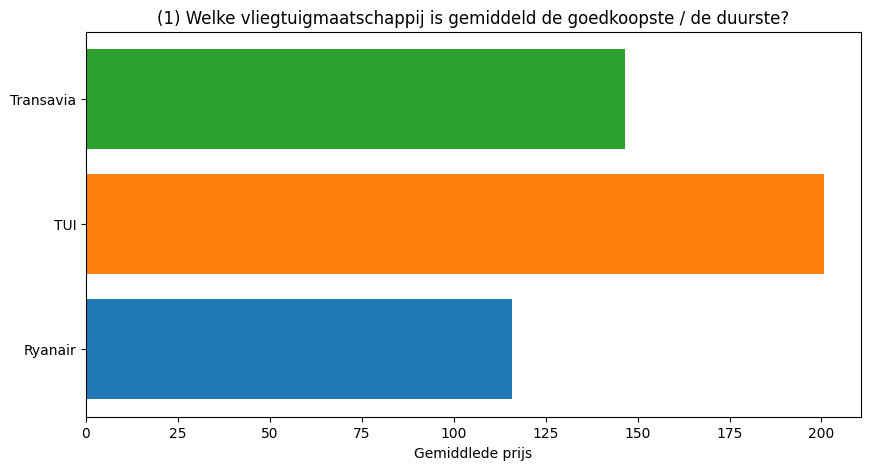

In [8]:
plt.figure(figsize=(10, 5))

carrier_codes = ['FR', 'TB', 'HV']
carrier_names = ['Ryanair', 'TUI', 'Transavia']

carrier_mean_prices = [ryanair_mean_price, tui_mean_price, transavia_mean_price]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

plt.barh(carrier_names, carrier_mean_prices, color=colors)
plt.title('(1) Welke vliegtuigmaatschappij is gemiddeld de goedkoopste / de duurste?')
plt.xlabel('Gemiddlede prijs')

### (8) Zijn de prijzen gerelateerd aan vakantieperiodes hier of ter plaatse?

In [77]:
df_date['fullDate'] = pd.to_datetime(df_date['fullDate'])
df_date = df_date.drop(df_date.index[184:])
df_date = df_date.reset_index(drop=True)

In [78]:
df_flight_on_vacation_day = pd.merge(df_fact_flights, df_date, left_on='departureDateID', right_on='dateID')

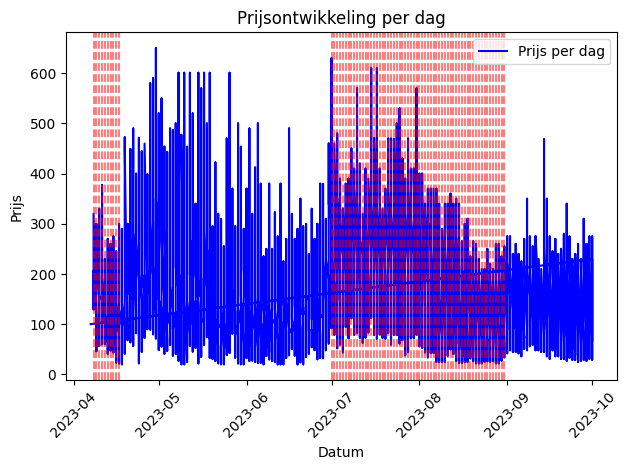

In [79]:
plt.plot(df_flight_on_vacation_day['fullDate'], df_flight_on_vacation_day['adultPrice'], color='blue', label='Prijs per dag')

for _, row in df_date.iterrows():
    if row['isItVacationDay'] == 1:
        plt.axvline(x=row['fullDate'], color='red', linestyle='--', alpha=0.5)

plt.title('Prijsontwikkeling per dag')
plt.xlabel('Datum')
plt.ylabel('Prijs')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### (9) Kan je de prijsstrategie afleiden? (Invloed van aantal dagen voor vertrek, invloed van beschikbaarheid)

### (12) Hoeveel dagen voor vertrek is een vlucht volgeboekt? Zijn er bestemmingen waarbij de vluchten bijna volgeboekt zijn?

C:\Users\marlo\AppData\Local\Temp\ipykernel_8108\1220893232.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fully_booked_df['days_before_departure'] = (pd.to_datetime(fully_booked_df['departureDateID'], unit='s') - pd.to_datetime(fully_booked_df['scrapeDateID'], unit='s')).dt.days


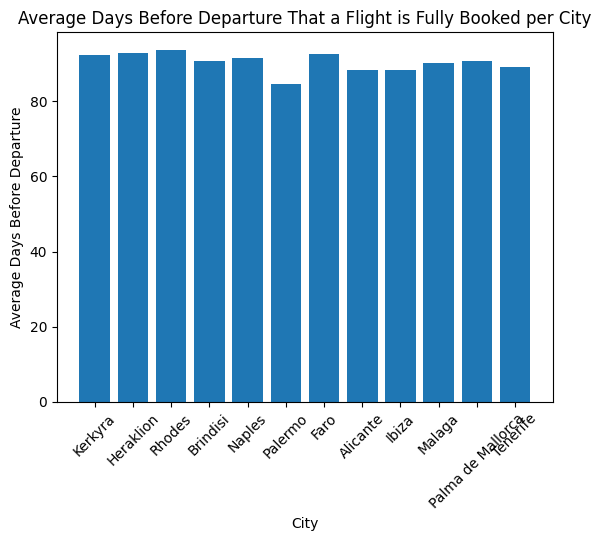

In [38]:
fully_booked_df = df_fact_flights[df_fact_flights['availableSeats'] == -1] 

fully_booked_df['days_before_departure'] = (pd.to_datetime(fully_booked_df['departureDateID'], unit='s') - pd.to_datetime(fully_booked_df['scrapeDateID'], unit='s')).dt.days

average_days_before_departure = fully_booked_df.groupby('arrAirportID')['days_before_departure'].mean()

city_names = df_airport[df_airport['airportID'].isin(average_days_before_departure.index)]['city']

plt.bar(city_names, average_days_before_departure)
plt.xlabel('City')
plt.ylabel('Average Days Before Departure')
plt.title('Average Days Before Departure That a Flight is Fully Booked per City')
plt.xticks(rotation=45)
plt.show()

### (13) Hoeveel procent van de vluchten zijn volgeboekt? / Hoeveel plaatsen zijn er nog vrij 5 dagen voor vertrek.

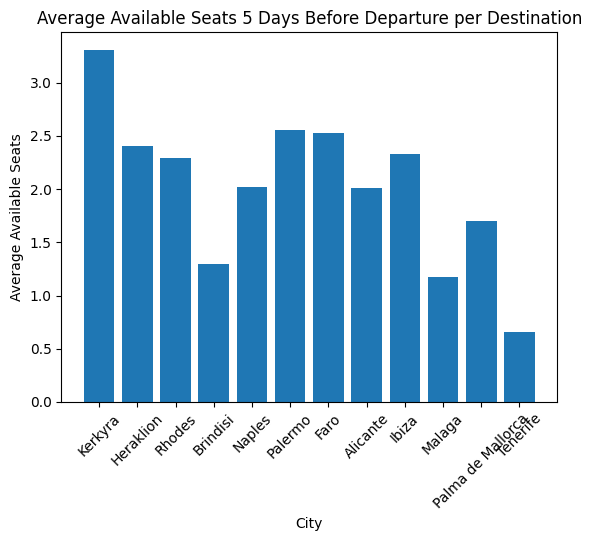

In [12]:
from datetime import timedelta

depDate = pd.to_datetime(df_fact_flights['departureDateID'], unit='s')
scrapeDate = pd.to_datetime(df_fact_flights['scrapeDateID'], unit='s') 

filtered_df = df_fact_flights[depDate - scrapeDate == timedelta(days=5)] 
grouped_df = filtered_df.groupby('arrAirportID') 

average_available_seats_per_destination = grouped_df['availableSeats'].mean()

city_names = df_airport[df_airport['airportID'].isin(average_available_seats_per_destination.index)]['city']

plt.bar(city_names, average_available_seats_per_destination)
plt.xlabel('City')
plt.ylabel('Average Available Seats')
plt.title('Average Available Seats 5 Days Before Departure per Destination')
plt.xticks(rotation=45)
plt.show()

### (14 a.)  Plot het verband tussen de prijs en het aantal dagen voor vertrek voor Ryanair voor de afgelopen maand.

C:\Users\marlo\AppData\Local\Temp\ipykernel_8108\3673065926.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ryanair_flights['days_before_departure'] = (pd.to_datetime(ryanair_flights['departureDateID'], unit='s') - pd.to_datetime(ryanair_flights['scrapeDateID'], unit='s')).dt.days


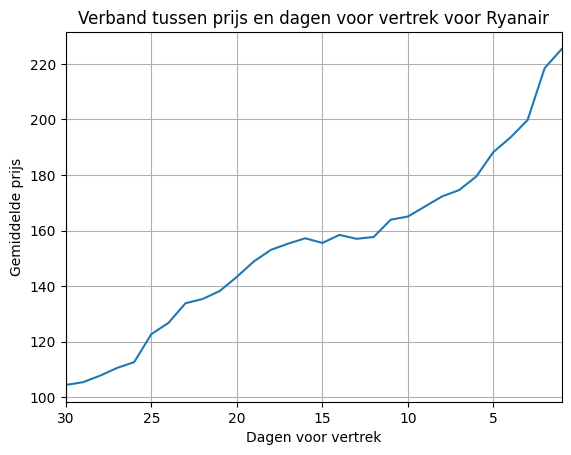

In [54]:
### Voor alle data van Ryanair

ryanair_flights = df_fact_flights[df_fact_flights['carrierID'] == 3] 

ryanair_flights['days_before_departure'] = (pd.to_datetime(ryanair_flights['departureDateID'], unit='s') - pd.to_datetime(ryanair_flights['scrapeDateID'], unit='s')).dt.days

ryanair_flights_30_days = ryanair_flights[ryanair_flights['days_before_departure'] <= 30]

average_prices = ryanair_flights_30_days.groupby('days_before_departure')['adultPrice'].mean().sort_index(ascending=False)

plt.plot(average_prices.index, average_prices.values)
plt.xlabel('Dagen voor vertrek')
plt.ylabel('Gemiddelde prijs')
plt.title('Verband tussen prijs en dagen voor vertrek voor Ryanair')
plt.xlim(max(average_prices.index), min(average_prices.index))
plt.grid()
plt.show()

In [55]:
### Voor data van de afgelopen maand van Ryanair (werkt niet)

today = datetime.now()
one_month_ago = today + relativedelta(months=-1)
one_month_ago.strftime('%Y-%m-%d')

ryanair_flights = df_fact_flights[(df_fact_flights['carrierID'] == 3) & (pd.to_datetime(df_fact_flights['departureDateID'], unit='s') >= one_month_ago)]

ryanair_flights_30_days = ryanair_flights[ryanair_flights['days_before_departure'] <= 30]

average_prices = ryanair_flights_30_days.groupby('days_before_departure')['adultPrice'].mean().sort_index(ascending=False)

plt.plot(average_prices.index, average_prices.values)
plt.xlabel('Dagen voor vertrek')
plt.ylabel('Gemiddelde prijs')
plt.title('Verband tussen prijs en dagen voor vertrek voor Ryanair')
plt.xlim(max(average_prices.index), min(average_prices.index))
plt.grid()
plt.show()

KeyError: 'days_before_departure'

### (14 b.) Maak gebruik van regressie om de prijzen te voorspellen voor de volgende maand. Lineaire regressie is voldoend